In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
from scipy import stats
import os

In [3]:
exponent=1
dir_name = "data_json"

# Scale factor vs shuffle amount

In [4]:
def load_network_errors(shuffle_amount, scale_factor):
    randoms = np.arange(10)
    errors = []
    for random in randoms:
        filename = f"hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa{shuffle_amount:1}_sf{scale_factor:1}_e{exponent:.1f}_dp1.0_r{random}"
        filename = f"{dir_name}/{filename}.json"
        if os.path.isfile(filename):
            with open(filename) as f: info = json.load(f)
            errors.append(info["error_distractor"][2])
        else:
            print(f"does not exist: {filename}")
    return np.array(errors)

In [26]:
np.arange(2, 4.1, 0.25, dtype="float")

array([2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 , 3.75, 4.  ])

In [27]:
shuffle_amounts = np.arange(0, 161, 10, dtype="float")
shuffle_amounts = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160], dtype="float")#np.arange(0, 161, 10, dtype="float")
scale_factors = np.array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25, 3.5 , 3.75, 4.  ])
error_means = np.zeros((len(shuffle_amounts), len(scale_factors)), "float")

for i, shuffle_amount in enumerate(shuffle_amounts):
    for j, scale_factor in enumerate(scale_factors):
        errors = load_network_errors(shuffle_amount, scale_factor)
        error_means[i, j] = np.mean(errors)

does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa0.0_sf1.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa10.0_sf1.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa70.0_sf1.45_e1.0_dp1.0_r8.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa70.0_sf1.45_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa130.0_sf3.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa135.0_sf3.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa135.0_sf4.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa140.0_sf3.0_e1.0_dp1.0_r9.json


In [37]:
len(shuffle_amounts)

23

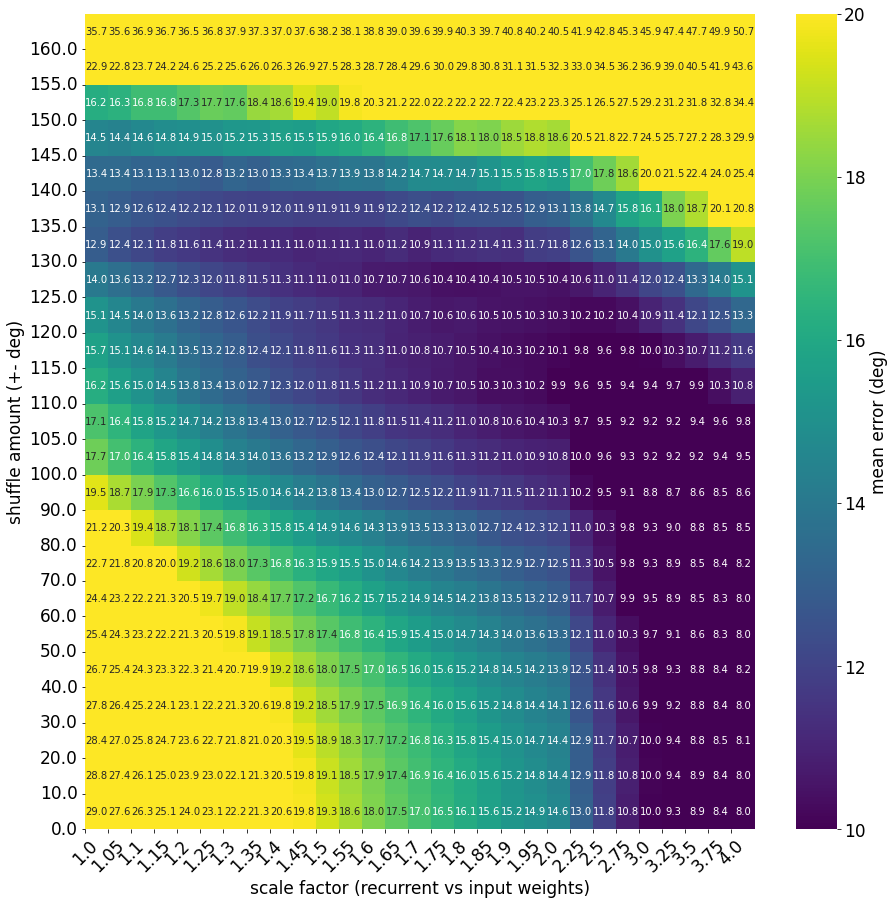

In [43]:
fig = plt.figure(figsize=(15, 15))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ax = sns.heatmap(error_means, cmap="viridis", annot=((error_means*10).astype(int)/10).astype(str), annot_kws={'fontsize': 10}, fmt='s', vmin=10, vmax=20, cbar_kws={'label': 'mean error (deg)'})
ax.invert_yaxis()
plt.xticks(range(len(scale_factors)), scale_factors, rotation=45)
plt.yticks(range(len(shuffle_amounts)), shuffle_amounts, rotation=0)
ax.set_xlabel("scale factor (recurrent vs input weights)")
ax.set_ylabel("shuffle amount (+- deg)")
plt.show()

# Structural vs Functional Connectivity

In [126]:
shuffle_amount = 80.0
scale_factor = 1.0

def load_structural_functional_connectivity_and_error(shuffle_amount, scale_factor, random):
    filename = f"hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa{shuffle_amount:1}_sf{scale_factor:1}_e{exponent:.1f}_dp1.0_r{random}"
        
    filename1 = f"{dir_name}/{filename}.json"
    if os.path.isfile(filename1):
        with open(filename1) as f: info = json.load(f)
        info = {"error": info["error_distractor"][2], "error_nodistractor": info["error_nodistractor"][2]}
    else:
        print(f"does not exist: {filename1}")
        return None

    filename2 = f"{dir_name}/{filename}_connectivity.json"
    if os.path.isfile(filename2):
        with open(filename2) as f: info.update(json.load(f))
    else:
        print(f"does not exist: {filename2}")
        return None
        
    return info

        
factors = np.zeros((len(shuffle_amounts), len(scale_factors), 10, 6), "float") #structural, functional

for i, shuffle_amount in enumerate(shuffle_amounts):
    for j, scale_factor in enumerate(scale_factors):
        for k in range(10):
            res = load_structural_functional_connectivity_and_error(shuffle_amount, scale_factor, k)
            if res is None: continue
            factors[i, j, k] = [res["error"], res["structural_factor"], res["functional_factor"], scale_factor, shuffle_amount, res["error_nodistractor"]]

does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa0.0_sf1.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa10.0_sf1.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa70.0_sf1.45_e1.0_dp1.0_r8.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa70.0_sf1.45_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa130.0_sf3.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa135.0_sf3.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa135.0_sf4.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa140.0_sf3.0_e1.0_dp1.0_r9.json
does not exist: data_json/hdreshuffle_and_ratioCTRNN_2DIR1O_dr100_n0.1_la0_sa155.0_sf2.75_e1.0_dp1.0_r9_connectivity.json
does not exist: d

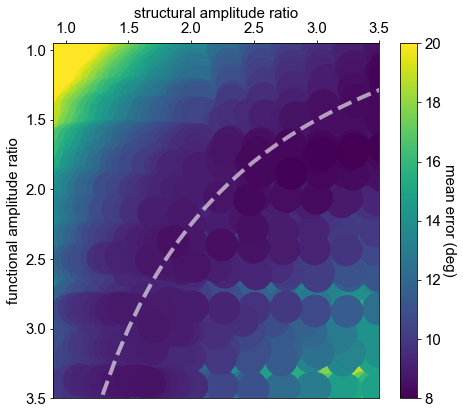

In [127]:
fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 15})

vmin, vmax = 8, 20

sf = factors.reshape(-1, 6)[:, 3]
sa = factors.reshape(-1, 6)[:, 4]
filter = sa < 200

x = factors.reshape(-1, 6)[:, 1][filter]
y = factors.reshape(-1, 6)[:, 2][filter]
e = np.clip(factors.reshape(-1, 6)[:, 0], vmin, vmax)[filter]

order = np.arange(len(e))
order = np.argsort(e)[::-1]
scatter = plt.scatter(x[order], y[order], 1000, alpha=1, c=e[order], cmap='viridis', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(scatter)
cbar.set_label('mean error (deg)', rotation=270, labelpad=15)

xx = np.linspace(0.1, 10, 100)
plt.plot(xx, 4.5/xx, "--", color="white", alpha=0.6, linewidth=4, label="structural * functional = 4.5")

plt.ylabel("functional amplitude ratio")
plt.xlabel("structural amplitude ratio")
#plt.legend(loc=1)

plt.ylim(.95, 3.5)
plt.xlim(.9, 3.5)
plt.gca().invert_yaxis()
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().xaxis.set_label_position('top') 
plt.tight_layout()
plt.savefig('paper_figures/_structural_functional_ratio.pdf', bbox_inches='tight')

/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_73560/1211031142.py:10: RuntimeWarning: divide by zero encountered in true_divide
  x = 1/factors.reshape(-1, 6)[:, 1][filter]
/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_73560/1211031142.py:11: RuntimeWarning: divide by zero encountered in true_divide
  y = 1/factors.reshape(-1, 6)[:, 2][filter]


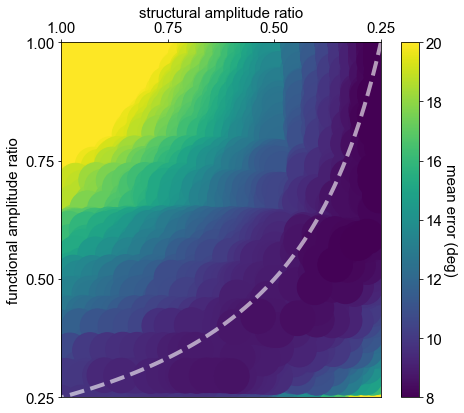

In [128]:
fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 15})

vmin, vmax = 8, 20

sf = factors.reshape(-1, 6)[:, 3]
sa = factors.reshape(-1, 6)[:, 4]
filter = sa < 200

x = 1/factors.reshape(-1, 6)[:, 1][filter]
y = 1/factors.reshape(-1, 6)[:, 2][filter]
e = np.clip(factors.reshape(-1, 6)[:, 0], vmin, vmax)[filter]

order = np.arange(len(e))
order = np.argsort(e)[::-1]
scatter = plt.scatter(x[order], y[order], 1200, alpha=1, c=e[order], cmap='viridis', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(scatter)
cbar.set_label('mean error (deg)', rotation=270, labelpad=15)

xx = np.linspace(0.01, 1, 100)
plt.plot(xx, 1/4/xx, "--", color="white", alpha=0.6, linewidth=4, label="structural * functional = 4.5")

plt.ylabel("functional amplitude ratio")
plt.xlabel("structural amplitude ratio")
#plt.legend(loc=1)

plt.ylim(1, 1/4)
plt.xlim(1, 1/4)
plt.xticks([1, 0.75, 0.5, 0.25])
plt.yticks([1, 0.75, 0.5, 0.25])
plt.gca().invert_yaxis()
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().xaxis.set_label_position('top') 
plt.tight_layout()
plt.savefig('paper_figures/_structural_functional_ratio.pdf', bbox_inches='tight')

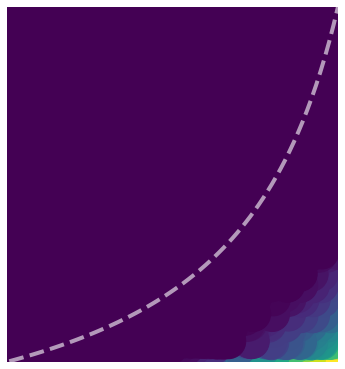

In [65]:
fig = plt.figure(figsize=(4*1.5, 4*1.5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 15})
e = np.clip(factors.reshape(-1, 6)[:, -1], vmin, vmax)[filter]

order = np.arange(len(e))
order = np.argsort(e)[::-1]
scatter = plt.scatter(x[order], y[order], 1200, alpha=1, c=e[order], cmap='viridis', vmin=vmin, vmax=vmax)
cbar.set_label('mean error (deg)', rotation=270, labelpad=15)

xx = np.linspace(0.01, 1, 100)
plt.plot(xx, 1/4/xx, "--", color="white", alpha=0.6, linewidth=4, label="structural * functional = 4.5")

plt.ylabel("functional amplitude ratio")
plt.xlabel("structural amplitude ratio")
#plt.legend(loc=1)

plt.ylim(1, 1/4)
plt.xlim(1, 1/4)
plt.xticks([1, 0.75, 0.5, 0.25])
plt.yticks([1, 0.75, 0.5, 0.25])
plt.gca().invert_yaxis()
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().xaxis.set_label_position('top') 
plt.tight_layout()
plt.axis('off')
plt.savefig('paper_figures/_structural_functional_ratio_nodistractor.pdf', bbox_inches='tight')

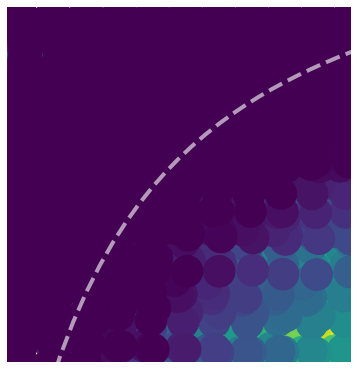

In [43]:
fig = plt.figure(figsize=(4*1.5, 4*1.5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 15})
e = np.clip(factors.reshape(-1, 6)[:, -1], vmin, vmax)[filter]

order = np.arange(len(e))
order = np.argsort(e)[::-1]
scatter = plt.scatter(x[order], y[order], 1000, alpha=1, c=e[order], cmap='viridis', vmin=vmin, vmax=vmax)
cbar.set_label('mean error (deg)', rotation=270, labelpad=15)

xx = np.linspace(0.1, 10, 100)
plt.plot(xx, 4.5/xx, "--", color="white", alpha=0.6, linewidth=4, label="structural * functional = 4.5")

plt.ylabel("functional amplitude ratio")
plt.xlabel("structural amplitude ratio")
#plt.legend(loc=1)

plt.ylim(.96, 3.5)
plt.xlim(.9, 3.5)
plt.gca().invert_yaxis()
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().xaxis.set_label_position('top') 
plt.tight_layout()
plt.axis('off')
plt.savefig('paper_figures/_structural_functional_ratio_nodistractor.pdf', bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 15})

vmin, vmax = 8, 20

sf = factors.reshape(-1, 6)[:, 3]
sa = factors.reshape(-1, 6)[:, 4]
filter = sa < 200

x = 1/factors.reshape(-1, 6)[:, 1][filter]
y = 1/factors.reshape(-1, 6)[:, 2][filter]
e = np.clip(factors.reshape(-1, 6)[:, 0], vmin, vmax)[filter]

order = np.arange(len(e))
order = np.argsort(e)[::-1]
scatter = plt.scatter(x[order], y[order], 1000, alpha=1, c=e[order], cmap='viridis', vmin=vmin, vmax=vmax)
cbar = plt.colorbar(scatter)
cbar.set_label('mean error (deg)', rotation=270, labelpad=15)

xx = np.linspace(0.01, 1, 100)
plt.plot(xx, 1/4.5/xx, "--", color="white", alpha=0.6, linewidth=4, label="structural * functional = 4.5")

plt.ylabel("functional amplitude ratio")
plt.xlabel("structural amplitude ratio")
#plt.legend(loc=1)

plt.ylim(1.05, 1/5)
plt.xlim(1.05, 1/5)
plt.gca().invert_yaxis()
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().xaxis.set_label_position('top') 
plt.tight_layout()

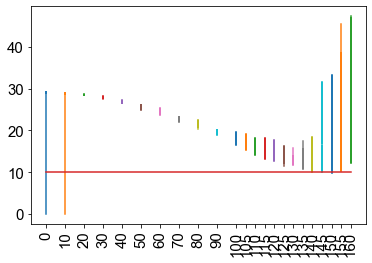

In [53]:
for i in range(23):
    plt.plot([shuffle_amounts[i]]*10, factors[i, 0, :, 0])
plt.xticks(shuffle_amounts, rotation=90)
plt.plot(shuffle_amounts, [10]*23)
plt.show()

/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_73560/4288712822.py:15: RuntimeWarning: divide by zero encountered in log
  t, k = np.log(t), np.log(k)
/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_73560/4288712822.py:15: RuntimeWarning: invalid value encountered in log
  t, k = np.log(t), np.log(k)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


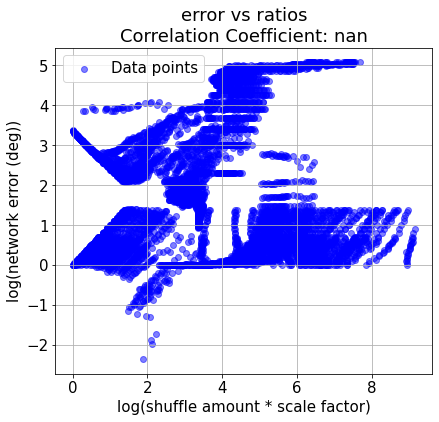

In [131]:
x = factors.reshape(-1, 5)[:, 1]
y = factors.reshape(-1, 5)[:, 2]
e = factors.reshape(-1, 5)[:, 0]
sf = factors.reshape(-1, 5)[:, 3]
sa = factors.reshape(-1, 5)[:, 4]

filter = (e<30) & (x>0.1) & (x<1.1) & (y>0.1) & (y<1.1) & (x*y>0.2)
#filter = (e<30) & (x>0.9) & (x<5.1) & (y>0.9) & (y<5.1) & (x*y<20.1)
filter = np.array([True] * len(e))


t = x[filter]*y[filter]
k = e[filter]

t, k = np.log(t), np.log(k)

fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15})

# Calculate the best-fit line
#slope, intercept = np.polyfit(t, k, 1)
#line = slope * t + intercept

# Calculate the correlation coefficient
corr_coeff = np.corrcoef(t, k)[0, 1]

# Create a scatter plot
plt.scatter(t, k, label='Data points', color='blue', alpha=0.5)

# Create a line plot for the best-fit line
#plt.plot(t, line, label=f'Best fit: y={slope:.2f}x+{intercept:.2f}', color='red')

# Add labels and a legend
plt.xlabel('log(shuffle amount * scale factor)')
plt.ylabel('log(network error (deg))')
plt.title(f'error vs ratios\nCorrelation Coefficient: {corr_coeff:.2f}')
plt.legend()

#plt.ylim(5, 30)
#plt.xlim(0.5, 15)

# Show the plot
plt.grid(True)
plt.show()

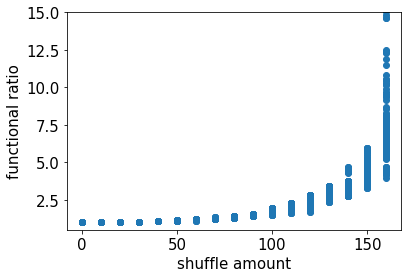

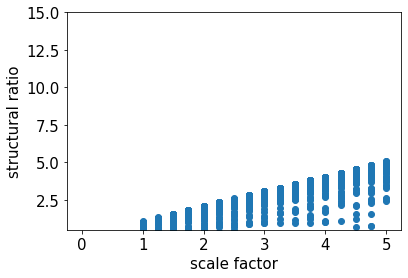

In [45]:
plt.scatter(sa[filter], y[filter])
plt.xlabel("shuffle amount")
plt.ylabel("functional ratio")
plt.ylim(0.5, 15)
plt.show()

plt.scatter(sf[filter], x[filter])
plt.xlabel("scale factor")
plt.ylabel("structural ratio")
plt.ylim(0.5, 15)
plt.show()

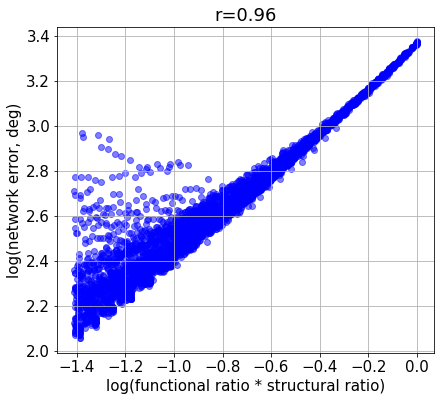

In [136]:
x = factors.reshape(-1, 6)[:, 1]
y = factors.reshape(-1, 6)[:, 2]
e = factors.reshape(-1, 6)[:, 0]

filter = (e<30) & (x>0.9) & (x<4.1) & (y>0.9) & (y<3.1) & (x*y<4.1)
#filter = (e<30) & (x>0.9) & (x<5.1) & (y>0.9) & (y<5.1) & (x*y<20.1)
#filter = np.array([True] * len(e))

t = 1/(x[filter]*y[filter])
k = e[filter]

t, k = np.log(t), np.log(k)

fig = plt.figure(figsize=(4.5*1.5, 4*1.5))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 15})

# Calculate the best-fit line
slope, intercept = np.polyfit(t, k, 1)
line = slope * t + intercept

# Calculate the correlation coefficient
corr_coeff = np.corrcoef(t, k)[0, 1]

# Create a scatter plot
plt.scatter(t, k, label='Data points', color='blue', alpha=0.5)

# Create a line plot for the best-fit line
#plt.plot(t, line, label=f'Best fit: y={slope:.2f}x+{intercept:.2f}', color='red')

# Add labels and a legend
plt.xlabel('log(functional ratio * structural ratio)')
plt.ylabel('log(network error, deg)')
plt.title(f'r={corr_coeff:.2f}')
#plt.legend()

#plt.ylim(5, 30)
#plt.xlim(0.5, 15)

# Show the plot
plt.grid(True)
plt.show()

# Backprop solutions functional/structural ratios

In [66]:
def load_backprop_structural_functional_connectivity_and_error(random):
    dir_name = "data_"
    filename = f"backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r{random}"
        
    filename1 = f"data/{filename}/info.json"
    if os.path.isfile(filename1):
        with open(filename1) as f: info = json.load(f)
        info = {"error": info["error_distractor"][2], "error_nodistractor": info["error_nodistractor"][2]}
    else:
        print(f"does not exist: {filename1}")
        return None

    filename2 = f"data_json/{filename}_connectivity.json"
    if os.path.isfile(filename2):
        with open(filename2) as f: info.update(json.load(f))
    else:
        print(f"does not exist: {filename2}")
        return None
        
    return info

In [67]:
factors = np.zeros((30, 6), "float") #structural, functional

for k in range(30):
    res = load_backprop_structural_functional_connectivity_and_error(k)
    if res is None: continue
    factors[k] = [res["error"], res["structural_factor"], res["functional_factor"], scale_factor, shuffle_amount, res["error_nodistractor"]]

does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r2_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r4_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r8_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r13_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r15_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r16_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r17_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r21_connectivity.json
does not exist: data_json/backpropCTRNN_2DIR1O_dr100_n0.1_la0_e1_dp1.0_r28_connectivity.json


/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_73560/3727805416.py:9: RuntimeWarning: divide by zero encountered in true_divide
  x = 1/(factors.reshape(-1, 6)[:, 1])
/var/folders/47/5g669ycs2t17c0kkg2_np43m0000gn/T/ipykernel_73560/3727805416.py:10: RuntimeWarning: divide by zero encountered in true_divide
  y = 1/(factors.reshape(-1, 6)[:, 2])


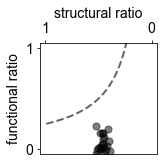

In [123]:
fig = plt.figure(figsize=(2.5, 2.5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})

vmin, vmax = 8, 20

sf = factors.reshape(-1, 6)[:, 3]
sa = factors.reshape(-1, 6)[:, 4]

x = 1/(factors.reshape(-1, 6)[:, 1])
y = 1/(factors.reshape(-1, 6)[:, 2])
structural = x
functinoal = y
e = np.clip(factors.reshape(-1, 6)[:, 0], vmin, vmax)

order = np.arange(len(e))
order = np.argsort(e)[::-1]
scatter = plt.scatter(x[order], y[order], 50, alpha=.5, color="k")
cbar.set_label('mean error (deg)', rotation=270, labelpad=15)

xx = np.linspace(0.01, 1, 100)
plt.plot(xx, 1/4/xx, "--", color="black", alpha=0.6, linewidth=2, label="structural * functional = 4.5")

plt.ylabel("functional ratio")
plt.xlabel("structural ratio")
#plt.legend(loc=1)

plt.ylim(1.05, -0.05)
plt.xlim(1.05, -0.05)
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.gca().invert_yaxis()
plt.gca().tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.gca().xaxis.set_label_position('top') 
plt.tight_layout()
plt.savefig(f'paper_figures/_structural_functional_ratio_backprop.pdf', bbox_inches='tight')

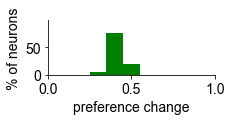

In [94]:
from matplotlib.ticker import FormatStrFormatter
import torch
fig = plt.figure(figsize=(3, 1))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})
ylim = 99
ax = fig.add_subplot(1, 1, 1)
bins = 10
hist = torch.histc(torch.tensor(structural), bins = bins, min = 0, max = 1)
hist /= torch.sum(hist)
x = torch.arange(bins)/bins
ax.bar(x, hist*100, align='center', width=.1, color="green")
ax.set_xlabel('preference change')
ax.set_ylabel('% of neurons')
ax.set_ylim(0, ylim)
ax.set_xlim(0, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.savefig(f'{figure_dir_prefix}{directory[5:-1]}_prefchange.pdf', bbox_inches='tight')
